In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

In [ ]:
file = '/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EPEML/pkls_etalabel/all_JZs_format1.pkl'
all_sample = pd.read_pickle(file)

In [ ]:
all_JZs_list = []
for key, value in all_sample.items():
    all_JZs_list.append(value)

all_jets = pd.concat(all_JZs_list)

In [ ]:
all_jets = all_jets.drop('event', axis = 1)

## Physical weights

In [ ]:
fig, ax = plt.subplots()
pt_edges = np.linspace(500, 2000, 61)
bin_contents, bin_edges, _ = ax.hist(all_jets['jet_pt'], bins=pt_edges, weights=all_jets['total_weight'])
ax.set_yscale('log')
plt.plot()


## Flatten Pt

### Plot

In [ ]:
flat_weight_factor = 1./bin_contents
pt_binned_sample_alljets_idx = np.digitize(all_jets['jet_pt'], pt_edges)

In [ ]:
all_jets['flatpt_weight'] = all_jets['total_weight']

In [ ]:
for i in tqdm(range(np.max(pt_binned_sample_alljets_idx))):
    mod_idx = np.where(pt_binned_sample_alljets_idx-1 == i)[0]
    all_jets.iloc[mod_idx, all_jets.columns.get_loc('flatpt_weight')] *= flat_weight_factor[i]
    ## df.iloc[0, df.columns.get_loc('COL_NAME')] = x

In [ ]:
fig, ax = plt.subplots()
pt_edges = np.linspace(500, 2000, 61)
bin_contents, bin_edges, _ = ax.hist(all_jets['jet_pt'], bins=pt_edges, weights=all_jets['flatpt_weight'])
# ax.set_yscale('log')
plt.plot()


### Adjust the columns 

In [ ]:
all_jets['equal_weight'] = np.ones(len(all_jets))

In [ ]:
all_jets

In [ ]:
all_jets.rename(columns = {'total_weight':'event_weight'}, inplace = True)
col_list = list(all_jets)
print(col_list)

In [ ]:
insert_pos = col_list.index('event_weight')
adj_col_list = col_list[:insert_pos] + ['equal_weight'] + [col_list[insert_pos]] + [col_list[-2]] + col_list[insert_pos+2:-2]

In [ ]:
adj_col_list

In [ ]:
all_jets = all_jets.reindex(columns = adj_col_list)
all_jets = all_jets[all_jets['event_weight'] != 0]

In [ ]:
all_jets.head()

In [ ]:
all_jets.to_pickle("./sample_all_jets.pkl")

In [ ]:
with open("./sample_all_jets.pkl", 'rb') as f:
    all_jets = pd.read_pickle(f)

## Sample 1500GeV

### 2.8M jets

In [ ]:
sample_1500 = all_jets[(all_jets['jet_pt'] >= 1500) & (all_jets['jet_PartonTruthLabelID'] != -1)]

In [ ]:
sample_1500.head()

In [ ]:
sample_1500.describe()

In [ ]:
sample_1500.to_pickle("./sample_1500_all_jets.pkl")

In [ ]:
with open("./sample_1500_all_jets.pkl", 'rb') as f:
    test_sample = pd.read_pickle(f)

In [ ]:
sum(test_sample['target']==1)

In [ ]:
sum(test_sample['target']==0)

In [ ]:
sample_quark = sample_1500[sample_1500['target']==0]
sample_gluon = sample_1500[sample_1500['target']==1]

n_quark = len(sample_quark)
n_gluon = len(sample_gluon)

In [ ]:
n_sample = np.min([n_quark, n_gluon])

In [ ]:
subset_sample_quark = sample_quark.sample(n=n_sample)
subset_sample_gluon = sample_gluon.sample(n=n_sample)


In [ ]:
subset_sample_1500 = pd.concat([subset_sample_quark, subset_sample_gluon])

In [ ]:
len(subset_sample_1500)

In [ ]:
subset_sample_1500.to_pickle("./sample_1500_2p8M_jets.pkl")

### 200k jets

In [ ]:
all_jets = "./sample_all_jets.pkl" 

with open(all_jets, 'rb') as f:
    all_jets = pd.read_pickle(f)



In [ ]:
all_jets.head()

In [ ]:
sample_1500 = all_jets[(all_jets['jet_pt'] >= 1500) & (all_jets['jet_PartonTruthLabelID'] != -1)]

In [ ]:
n_sample = 100_000
sample_quark = sample_1500[sample_1500['target']==0]
sample_gluon = sample_1500[sample_1500['target']==1]
subset_sample_quark = sample_quark.sample(n=n_sample, random_state=42)
subset_sample_gluon = sample_gluon.sample(n=n_sample, random_state=42)
subset_sample_1500 = pd.concat([subset_sample_quark, subset_sample_gluon])
subset_sample_1500.to_pickle("./sample_1500_200k_jets.pkl")

In [ ]:
subset_sample_1500.tail()

# Sample 12M jets 

In [ ]:
all_jets = "./sample_all_jets.pkl" 

with open(all_jets, 'rb') as f:
    all_jets = pd.read_pickle(f)

In [ ]:
all_jets.shape

In [ ]:
all_jets.head()

In [ ]:
#### Remove 
all_jets = all_jets[(all_jets['jet_PartonTruthLabelID'] != -1) & (all_jets['jet_nTracks'] >= 2)]

In [ ]:
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]
all_jets['pt_idx'] = pd.cut(x=all_jets['jet_pt'], bins=label_pt_bin, right=False, labels=False)


In [ ]:
quark_jets = all_jets[all_jets['target'] == 0]
gluon_jets = all_jets[all_jets['target'] == 1]
n_sample_ptbin = 1_000_000
jets_list = []

for jets in [quark_jets, gluon_jets]:
    for pt_idx, pt in enumerate(label_pt_bin[:-1]):
        jets_pt = jets[jets['pt_idx'] == pt_idx] 
        jets_list.append(jets_pt.sample(n=n_sample_ptbin, random_state = 42))

In [ ]:
jets_allpt_12M = pd.concat(jets_list)

In [ ]:
jets_allpt_12M.shape

In [ ]:
jets_allpt_12M.to_pickle("./sample_allpt_12M_jets.pkl")

In [4]:
all_jets = "./sample_allpt_all_jets.pkl" 

with open(all_jets, 'rb') as f:
    all_jets = pd.read_pickle(f)

In [5]:
all_jets.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target
0,766.747925,1.298662,2.0,0.318292,0.215923,-0.192873,21.0,1.0,17.609434,2.703190e-05,1.0,1,1.0
0,680.507996,0.447689,24.0,0.064352,0.208339,0.066904,2.0,1.0,0.331535,2.858433e-07,0.0,1,0.0
1,619.839111,0.588775,34.0,0.115656,0.298206,0.232268,21.0,1.0,0.331535,1.655248e-07,1.0,1,1.0
2,721.692932,-0.716669,12.0,0.049718,0.220595,-0.169604,2.0,1.0,0.377624,3.935379e-07,0.0,1,0.0
3,697.332947,-1.042831,22.0,0.091199,0.278667,0.029374,21.0,1.0,0.377624,3.255802e-07,1.0,1,1.0


(array([5.9978808 , 5.99803981, 5.99818073, 5.9981648 , 5.99817481,
        5.99805082, 5.99746664, 5.9980671 , 5.99825024, 5.99840047]),
 array([ 500.00003052,  650.00001526,  800.        ,  949.99998474,
        1099.99996948, 1249.99995422, 1399.99993896, 1549.99992371,
        1699.99990845, 1849.99989319, 1999.99987793]),
 <BarContainer object of 10 artists>)

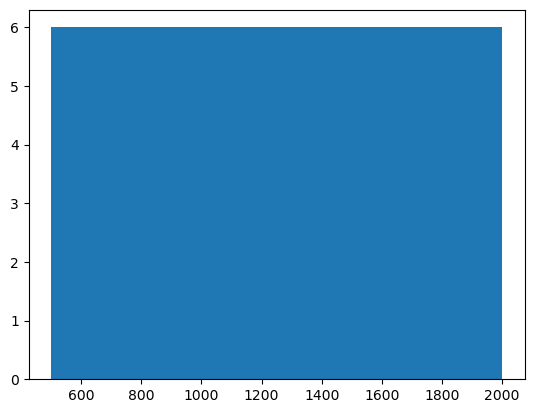

In [8]:
plt.hist(all_jets['jet_pt'], weights=all_jets['flatpt_weight'])

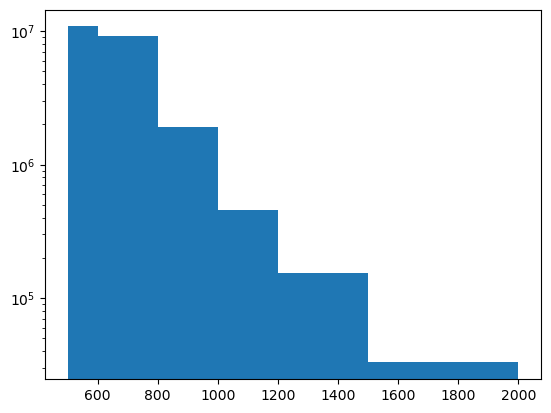

In [15]:
pt_edges = np.array([500, 600, 800, 1000, 1200, 1500, 2000])

plt.hist(all_jets['jet_pt'], weights=all_jets['event_weight'], bins=pt_edges)
plt.yscale('log')

In [10]:
pt_list = []
for i in range(5):
    sub_sample = all_jets[all_jets['pt_idx'] == i]
    pt_list.append(sub_sample.sample(1_000_000))

In [12]:
subsample = pd.concat(pt_list)

(array([0.28225643, 0.37336979, 1.15716404, 2.07477479, 2.46017263,
        0.        ]),
 array([ 500.,  600.,  800., 1000., 1200., 1500., 2000.]),
 <BarContainer object of 6 artists>)

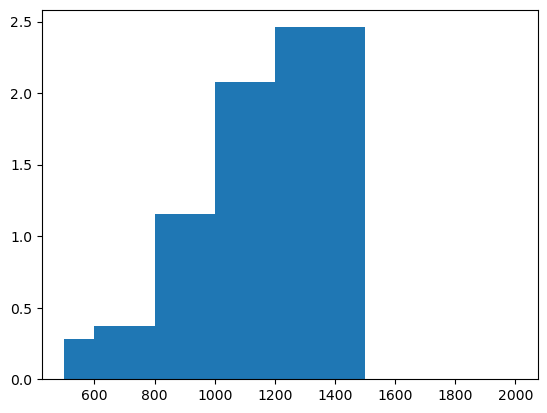

In [17]:
plt.hist(subsample['jet_pt'], weights=subsample['flatpt_weight'], bins=pt_edges)

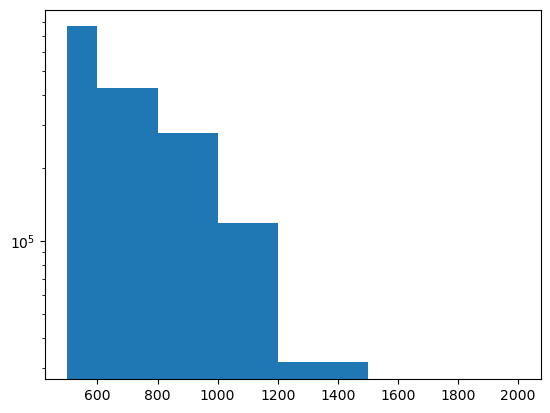

In [18]:
plt.hist(subsample['jet_pt'], weights=subsample['event_weight'], bins=pt_edges)
plt.yscale('log')